# NE 630 -  Lesson 40


**LAST TIME**: Perturbation theory

**TODAY**:  Numerical methods to answer questions like *What does the flux look like in two-group problems?* and *When is "diffusion theory" a good approximation?* 

**NEXT TIME**: Review & Practice

# Review: Perturbation Theory

For a bare slab of width $a$, and given $\phi(x)$, $\nu\Sigma_f(x)$, and $\Sigma_a(x)$, we can write

$$
  k = \frac{\text{gains}}{\text{losses}} = 
  \frac{\displaystyle \int^{a/2}_{-a/2} \nu\Sigma_f(x) \phi(x) dx}
       {\displaystyle\int^{a/2}_{-a/2} \Sigma_a(x) \phi(x) dx + \text{leakage}} \, .
\tag{1}      
$$

Now, given a new, slightly perturbed absorption cross section of $\Sigma_a(x) + \delta \Sigma_a$, what's $k$?

The **naïve** approach: just substitute $\Sigma_a = \Sigma_a + \delta \Sigma_a$ into Eq. (1) to get

$$
        \delta \rho  \approx
- \frac{ \displaystyle \int_{a/2}^{-a/2} 
   \delta\Sigma_a(x) \phi(x) dx}
   { \displaystyle \int_{-a/2}^{a/2}  \nu\Sigma_f(x) \phi(x) dx}\, .
   \tag{2}
$$

The **better** approach: weight the integrands by $\phi^*(x)=\phi(x)$:

$$
\delta \rho \approx - \frac{ \displaystyle \int_{-a/2}^{a/2} \phi^*(x) 
    \delta\Sigma_a(x)  \phi(x) dx}
   { \displaystyle \int_{-a/2}^{a/2} \phi^*(x) \nu\Sigma_f(x) \phi(x) dx}
\tag{3}
$$

Hint for HW 38:

- Is $\int x J_0^2(x) dx$ causing you grief?

$$
  \int x J_0^2(x) = \overbrace{\left [ \frac{x^2 J_0^2}{2} \right ]}^{uv}
  - \overbrace{\int x^2 J_0(x) J_1(x)dx}^{\int vdu} \, \quad \ldots \text{and so on...} = \displaystyle \frac{x^{2} J^{2}_{0}\left(x\right)}{2} + \frac{x^{2} J^{2}_{1}\left(x\right)}{2}
$$

In [1]:
import sympy as sy
x = sy.symbols('x')
sy.integrate(x*sy.besselj(0, x)**2)

x**2*besselj(0, x)**2/2 + x**2*besselj(1, x)**2/2

# On Two-Group Diffusion Theory

In [2]:
from detran import *
import numpy as np 
import matplotlib.pyplot as plt


plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

plt.rcParams['font.family'] = 'Serif'
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rcParams['font.size'] =  22
plt.rcParams['lines.linewidth'] = 2

In [3]:
def get_materials() :
    # Two-group data from 1-d coarse mesh benchmarks (Mosher, Ilas etc.)
    num_materials = 2
    num_groups = 2
    
    # Create the Materials object.
    mat = Material(num_materials, num_groups, "slabreactor");

    # ---------------------------
    # Material 0: Water
    # ---------------------------

    # Total
    mat.set_sigma_t(0, 0, 0.1890);       # (obj, matid, g, value);
    mat.set_sigma_t(0, 1, 1.4633);

    # Fission
    mat.set_sigma_f(0, 0, 0.0);         # Note, default is zero
    mat.set_sigma_f(0, 1, 0.0);
    mat.set_chi(0, 0, 0.0);
    mat.set_chi(0, 1, 0.0);

    # Scattering
    mat.set_sigma_s(0, 0, 0, 0.1507);    # 1 <- 1
    mat.set_sigma_s(0, 0, 1, 0.0000);    # 1 <- 2
    mat.set_sigma_s(0, 1, 0, 0.0380);    # 2 <- 1
    mat.set_sigma_s(0, 1, 1, 1.4536);    # 2 <- 2

    # ---------------------------
    # Material 1: Fuel 
    # ---------------------------

    # Total
    mat.set_sigma_t(1, 0, 0.2263);       # (obj, matid, g, value);
    mat.set_sigma_t(1, 1, 1.0119);

    # Fission
    mat.set_sigma_f(1, 0, 0.0067);
    mat.set_sigma_f(1, 1, 0.1241);
    mat.set_chi(1, 0, 1.0);
    mat.set_chi(1, 1, 0.0);

    # Scattering
    mat.set_sigma_s(1, 0, 0, 0.2006);    # 1 <- 1
    mat.set_sigma_s(1, 0, 1, 0.0000);    # 1 <- 2
    mat.set_sigma_s(1, 1, 0, 0.0161);    # 2 <- 1
    mat.set_sigma_s(1, 1, 1, 0.9355);    # 2 <- 2

    # ---------------------------
    # FINALIZE
    # ---------------------------
    mat.compute_diff_coef()
    mat.compute_sigma_a()
    mat.finalize();
    return mat

In [4]:
def get_mesh(a, t, n_a = 10, n_t = 10) :
    """ Return the mesh for a reflected reactor.
        a :  core width (cm)
        t :  reflector thickness (cm)
    """
    cm = [0.0, t, t + a, 2*t+a]
    fm = [n_t, n_a, n_t]
    mt = [0, 1, 0]
    mesh = Mesh1D(fm, cm, mt)
    return mesh

In [5]:
def get_base_input() :
    inp = InputDB()
    inp.put_int("number_groups",                  2)
    inp.put_int("dimension",                      1)
    inp.put_str("equation",                       "diffusion")
    inp.put_int("adjoint",                        0)
    inp.put_str("bc_west",                        "vacuum")
    inp.put_str("bc_east",                        "vacuum")
    inp.put_int("quad_number_polar_octant",       8)
    inp.put_str("eigen_solver",                   "PI")
    inp.put_dbl("eigen_tolerance",                1e-14)
    inp.put_int("eigen_max_iters",                1000)
    inp.put_str("outer_solver",                   "GMRES")
    inp.put_dbl("outer_tolerance",                1e-12)
    inp.put_int("outer_max_iters",                1000)
    inp.put_int("outer_print_level",              0)
    inp.put_int("outer_krylov_group_cutoff",      0)
    inp.put_str("outer_pc_type",                  "none")
    inp.put_int('mgpc_coarse_mesh_level',         5)
    inp.put_int('mgpc_condensation_option',       1)
    inp.put_int('mgpc_cmdsa_use_smoothing',       1)
    inp.put_int('mgpc_cmdsa_smoothing_iters',     2)
    inp.put_dbl('mgpc_cmdsa_smoothing_relax',     0.8)
    inp.put_str("inner_solver",                   "GMRES")
    inp.put_dbl("inner_tolerance",                1e-12)
    inp.put_int("inner_max_iters",                1000)
    inp.put_int("inner_print_level",              0)
    # gmres parameters
    db = InputDB("callow_db")
    db.put_dbl("linear_solver_atol",              0.0)
    db.put_dbl("linear_solver_rtol",              1e-13)
    db.put_str("linear_solver_type",              "gmres")
    db.put_int("linear_solver_maxit",             1000)
    db.put_int("linear_solver_gmres_restart",     50)
    db.put_int("linear_solver_monitor_level",     0)
    db.put_str("eigen_solver_type",               "power")
    db.put_int("eigen_solver_maxit",              1000)
    db.put_int("eigen_solver_monitor_level",      2)
    db.put_dbl("eigen_solver_tol",                1.0e-14)
    inp.put_spdb("inner_solver_db", db)
    inp.put_spdb("inner_pc_db", db)
    inp.put_spdb("outer_solver_db", db) 
    inp.put_spdb("eigen_solver_db", db)
    inp.put_int("store_angular_flux",             0)
    return inp


In [6]:
def plot_2g_flux(state, mesh, normalize=True):
    phi_0 = np.array(state.phi(0)) 
    phi_1 = np.array(state.phi(1)) 
    
    if normalize:
        # sets peak fast flux to 1 
        phi_1 = phi_1/max(phi_0)
        phi_0 = phi_0/max(phi_0)
    
    x = np.array([0]+list(np.cumsum([mesh.dx(i) for i in range(mesh.number_cells())])))
    fig = plt.figure()#(figsize=(8,4))
    plt.stairs(values=phi_0, edges=x, color="k", label="$\phi_{1}(x)$")
    plt.stairs(values=phi_1, edges=x, color="r", ls=':', label="$\phi_{2}(x)$")
    plt.title("$k_{eff}$ = " + f"{state.eigenvalue():.5f}" )
    plt.xlabel("$x$ [cm]")
    plt.legend() 
    return fig

In [7]:
mat = get_materials()
mesh = get_mesh(a=50, t=10, n_a=500, n_t=100)
inp = get_base_input()

In [8]:
manager = Eigen1D(inp, mat, mesh)
manager.solve()
state_diffusion = manager.state()

Solving eigenvalue problem...
Starting PI.
PI Iter:  10  Error:  0.000135749  keff:  1.133784806 
PI Iter:  20  Error:  0.000000149  keff:  1.133817134 
PI Iter:  30  Error:  0.000000000  keff:  1.133817169 
PI Iter:  40  Error:  0.000000000  keff:  1.133817169 
*********************************************************************
 PI Final: Number Iters:  46  Error: 8.856847547e-15 keff:  1.133817169 
*********************************************************************
PI done.


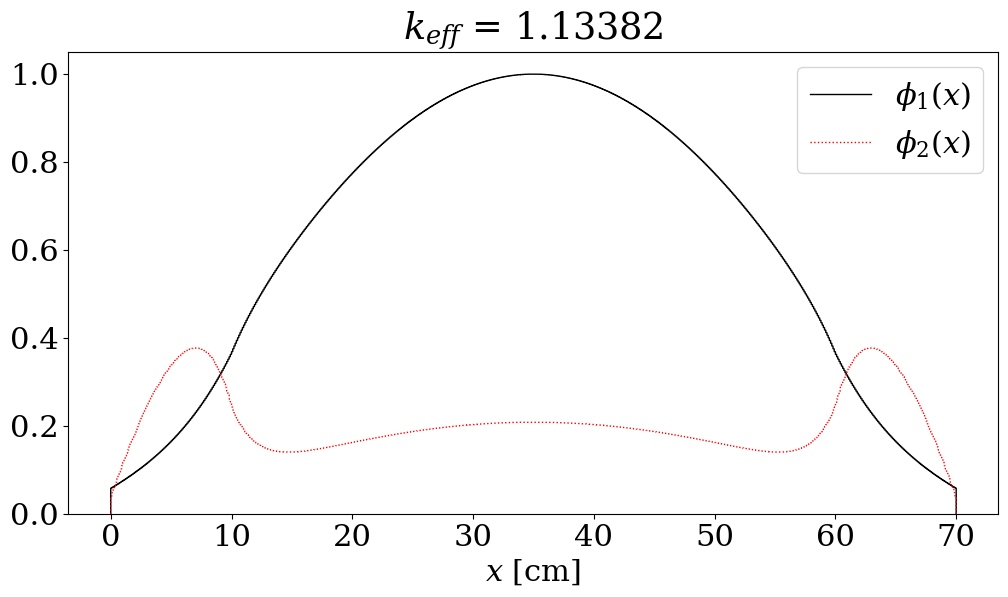

In [9]:
plot_2g_flux(state_diffusion, mesh);

For HW 37, you're using the modified 1-group equation, and without anything else, all we can do is write 

$$
   \phi_2(x) = \frac{\Sigma_{s_{2\gets 1}} \phi_1(x)}{\Sigma_{a_2}} \, .
$$


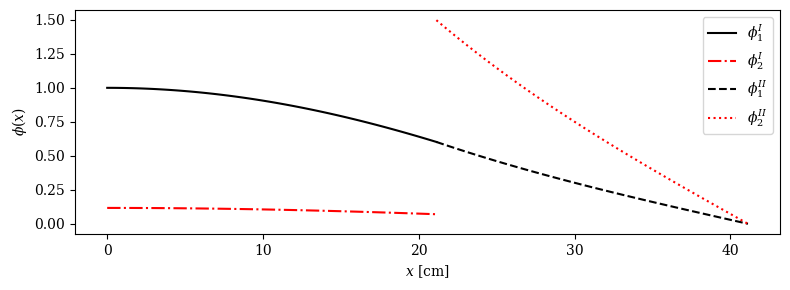

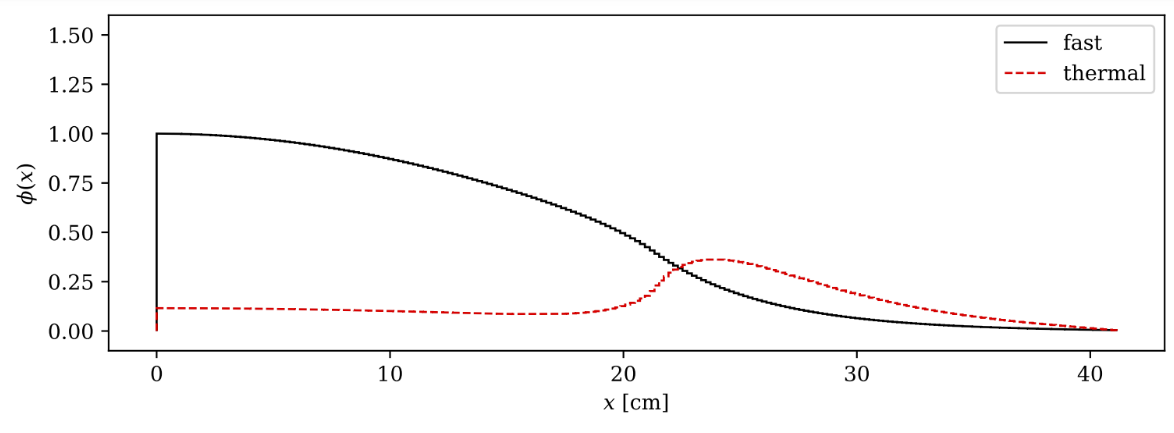

Solving eigenvalue problem...
Starting PI.
PI Iter:  10  Error:  0.000264419  keff:  1.133784750 
PI Iter:  20  Error:  0.000000306  keff:  1.133817132 
PI Iter:  30  Error:  0.000000000  keff:  1.133817169 
PI Iter:  40  Error:  0.000000000  keff:  1.133817169 
*********************************************************************
 PI Final: Number Iters:  49  Error: 7.338964506e-15 keff:  1.133817169 
*********************************************************************
PI done.


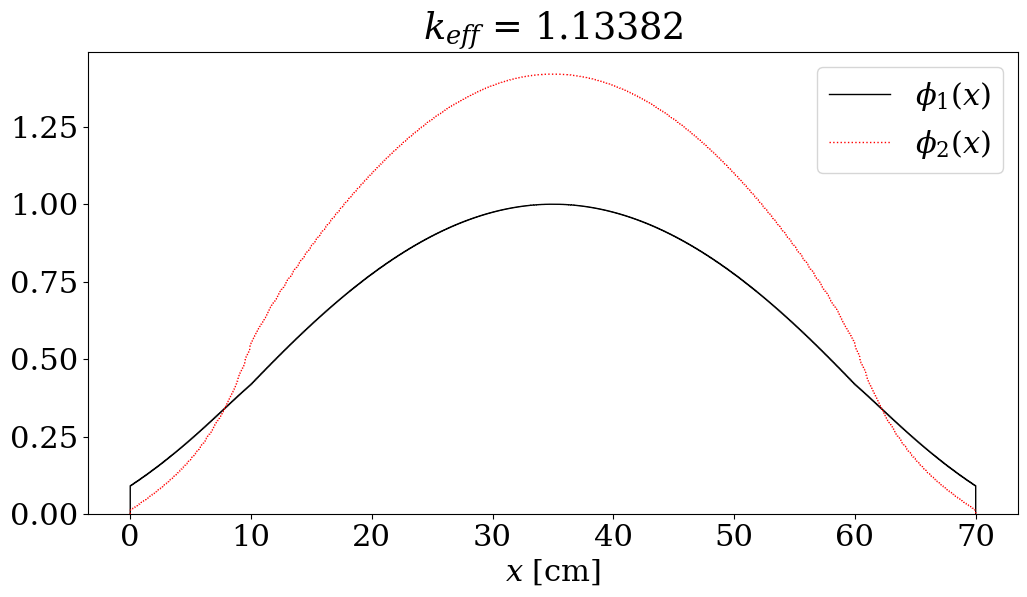

In [10]:
inp_A = get_base_input()
inp_A.put_int("adjoint", 1)
manager = Eigen1D(inp_A, mat, mesh)
manager.solve()
state_diffusion_A = manager.state()
plot_2g_flux(state_diffusion_A, mesh);

# On the Validity of Diffusion

What was our primary approximation to go from 

$$
  \vec{\nabla} \cdot \vec{J}(\vec{r})
  + \Sigma_a(\vec{r}) \phi(\vec{r}) = s'''(\vec{r})
  + \nu\Sigma_f(\vec{r}) \phi(\vec{r}) \, ,
  \tag{6.10}
$$

to

$$
 - \vec{\nabla} \cdot D(\vec{r}) \vec{\nabla} \phi(\vec{r})
  + \Sigma_a(\vec{r}) \phi(\vec{r}) = s'''(\vec{r})
  + \nu\Sigma_f(\vec{r}) \phi(\vec{r}) \, ?
  \tag{6.12}
$$


Answer: Fick's law, i.e., $\vec{J} \approx -D(\vec{r})\vec{\nabla}\phi(\vec{r})$

# Review Problem

Consider a slab of width 20 cm with $\Sigma_t = 1$ cm and $\Sigma_a = 0.01$ cm with a uniform source of strength $s'''=1$ [1/cm$^3$-s] subject to vacuum.  Find $\phi(x)$.

Last time, we started with

$$
 - \phi''(x) + \frac{1}{L^2}\phi(x) = \frac{s'''}{D} \, 
$$

and found that

$$
  \phi(x) = \overbrace{C_1 \cosh(x/L) + C_2 \sinh(x/L)}^{\phi_h} 
          + \overbrace{\frac{L^2 s'''}{D}}^{\phi_p} \, , 
$$

where $L^2 = D/\Sigma_a$, subject to $\phi(a/2) = \phi(-a/2) = 0$ (i.e., simple zero-flux conditions). 

Our right BC is 

$$
  \phi(a/2) = 0 = C_1 \cosh(a/2L) + C_2 \sinh(a/2L) + \frac{L^2 s'''}{D}  
$$

and our left BC is 

$$
\begin{split}
  \phi(-a/2) = 0 &= C_1 \cosh(-a/2L) + C_2 \sinh(-a/2L) + \frac{L^2 s'''}{D}  \\
             &= C_1 \cosh(a/2L) - C_2 \sinh(a/2L) + \frac{L^2 s'''}{D} 
\end{split}
$$

Subtract the left BC from the right BC to find 

$$
 2C_2 \sinh(a/2L) = 0 \quad \longrightarrow \quad C_2 = 0 \, .
$$

Then

$$
   C_1 \cosh(a/2L) = \frac{L^2 s'''}{D} \quad \longrightarrow \quad C_1 = -\frac{L^2 s'''}{D\cosh(a/2L)} \, ,
$$

and 

$$
\phi(x) = -\frac{L^2 s''' \cosh(x/L)}{D\cosh(a/2L)} + \frac{L^2 s'''}{D} = \boxed{ \frac{s'''}{\Sigma_a} \left (1 - \frac{\cosh(x/L)}{\cosh(a/2L)} \right )} \, .
$$


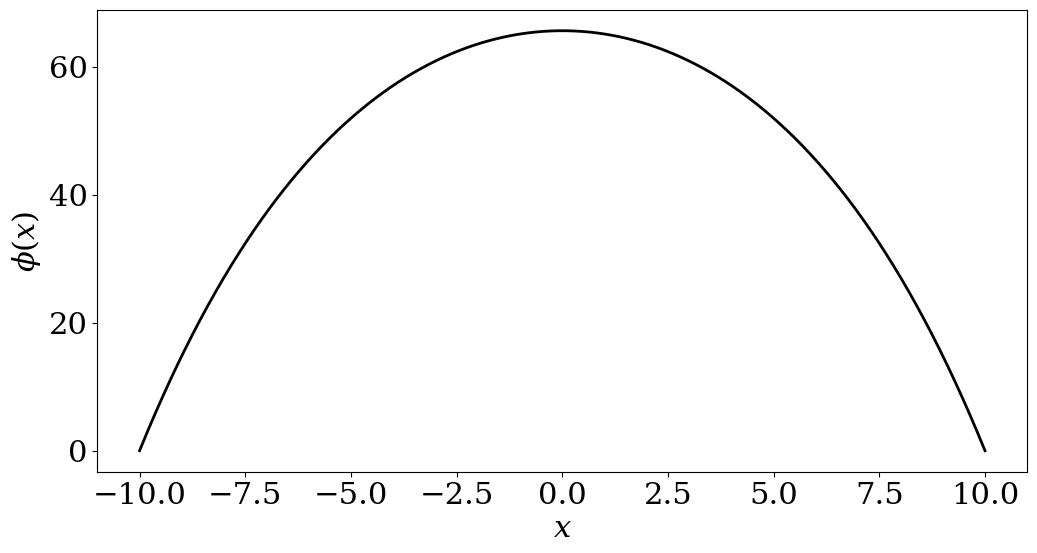

In [11]:

s = 1; D = 1/3; Sigma_a = 0.01; a = 20; L = np.sqrt(D/Sigma_a)
x = np.linspace(-a/2, a/2, 1000)
phi = (s/Sigma_a)*(1-np.cosh(x/L)/np.cosh(a/2/L))

plt.plot(x, phi, 'k'); plt.xlabel('$x$'); plt.ylabel("$\phi(x)$");

Now, how does this compare to the diffusion solution with vacuum? With the *neutron transport* solution?

In [12]:
#import sys
#sys.path.append("/home/robertsj/Research/detran/pydetran/build")

import detran
from detran import InputDB, Material, Fixed1D, Mesh1D, IsotropicSource

def get_input():
    """ fills default input parameters.
    """
    # Input
    inp = InputDB()
    inp.put_str("problem_type",       "fixed")
    inp.put_int("number_groups",      1)
    inp.put_str("equation",           "diffusion")
    inp.put_str("inner_solver",       "SI")
    inp.put_int("inner_max_iters",    10000)
    inp.put_dbl("inner_tolerance",    1e-12)
    inp.put_int("inner_print_level",  1)
    inp.put_int("outer_max_iters",    10000)
    inp.put_dbl("outer_tolerance",    1e-8)
    inp.put_int("outer_print_level",  1)    
    inp.put_str("quad_type",                  "gl")
    inp.put_int("quad_number_polar_octant",   32)
    inp.put_str("bc_west",                    "vacuum")
    inp.put_str("bc_east",                    "vacuum")
    db = InputDB("callow_db")
    db.put_dbl("linear_solver_atol",                  1e-12);
    db.put_dbl("linear_solver_rtol",                  1e-12);
    db.put_str("linear_solver_type",                  "gmres");
    db.put_int("linear_solver_maxit",                 5000);
    db.put_int("linear_solver_gmres_restart",         30);
    db.put_int("linear_solver_monitor_level",         0);
    db.put_str("pc_type", "ilut")
    db.put_int("ilu_levels", 1)
    db.put_dbl("ilu_thresh", 0)
    inp.put_spdb("inner_solver_db", db)
    inp.put_spdb("outer_solver_db", db)
    return inp

def get_material():
    mat = Material(4, 1)
    # original material - highly scattering
    mat.set_sigma_t(0, 0, 1.0)
    mat.set_sigma_s(0, 0, 0, 0.99)
    mat.set_diff_coef(0, 0, 1/3.0)
    # same total cross section (and, hence, D) but higher sigma_a
    mat.set_sigma_t(1, 0, 1.0)
    mat.set_sigma_s(1, 0, 0, 0.5)
    mat.set_diff_coef(1, 0, 1/3.0)
    # large cross section with pure absorption
    mat.set_sigma_t(2, 0, 5.0)
    mat.set_sigma_s(2, 0, 0, 0.0)
    mat.set_diff_coef(2, 0, 1/15.0)
    # cross section with sigma_s > sigma_t; numerically equivalent to k_oo>1
    mat.set_sigma_t(3, 0, 1.0)
    mat.set_sigma_s(3, 0, 0, 1.2)
    mat.set_diff_coef(3, 0, 1/3.0)
    # 
    mat.compute_sigma_a()
    mat.finalize()
    return mat

def get_mesh(material_map, source_map):
    # break our 20 cm into 20 regions
    cm = np.linspace(0, 20, 21)
    fm = [100]*20
    mesh = Mesh1D(fm, cm, material_map)
    mesh.add_coarse_mesh_map("SOURCE", source_map)
    return mesh

def solve(material_map, source_map, equation, bcL="vacuum", bcR="vacuum"):
    inp = get_input()
    inp.put_str("equation", equation)
    inp.put_str("bc_east", bcR)
    inp.put_str("bc_west", bcL)
    mat = get_material()
    mesh = get_mesh(material_map, source_map)
    solver = Fixed1D(inp, mat, mesh)
    solver.setup()
    source_fm_map = detran.vec_int(mesh.mesh_map("SOURCE"))
    # [#spec][#group].  here, we've got one group, and
    #  so [0.0] is the no-source, and [1.0] is the unit source.
    spectra = detran.vec2_dbl([[0.0], [1.0]])
    q_e = IsotropicSource(1, mesh, spectra, source_fm_map)
    solver.set_source(q_e)
    solver.set_solver()
    solver.solve()
    x = np.linspace(-10, 10, mesh.number_cells()+1)
    x = x[1:]-(x[1]-x[0])/2
    return np.array(solver.state().phi(0)), x

    SI Final: Number Iters: 1745  Error:  0.000000000  Sweeps:   1745 
  GS Final: Number Iters:   0  Error:  0.000000000  Sweeps:   1745 
PCILUT...construction complete.
    Starting SI.
      group 0


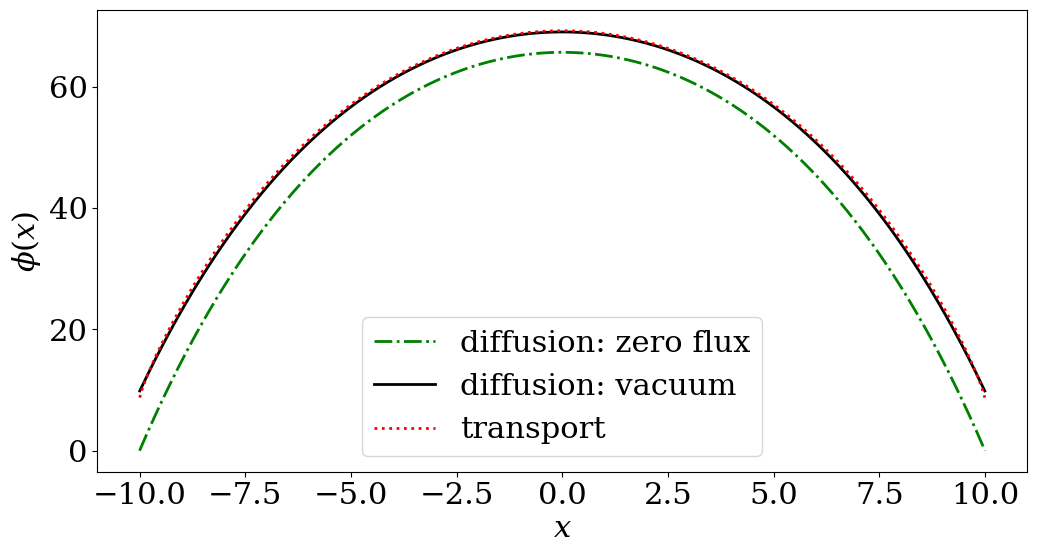

In [21]:
source_map = [1]*20
material_map = [0]*20
phi_diff, x_vals = solve(material_map, source_map, "diffusion")
phi_tran, x_vals = solve(material_map, source_map, "dd")


plt.plot(x, phi, 'g-.', label="diffusion: zero flux") 
plt.plot(x_vals, phi_diff, 'k', label="diffusion: vacuum")
plt.plot(x_vals, phi_tran, 'r:', label="transport")

plt.xlabel('$x$'); plt.ylabel("$\phi(x)$");
plt.legend();

Now, omit the zero-flux solution:

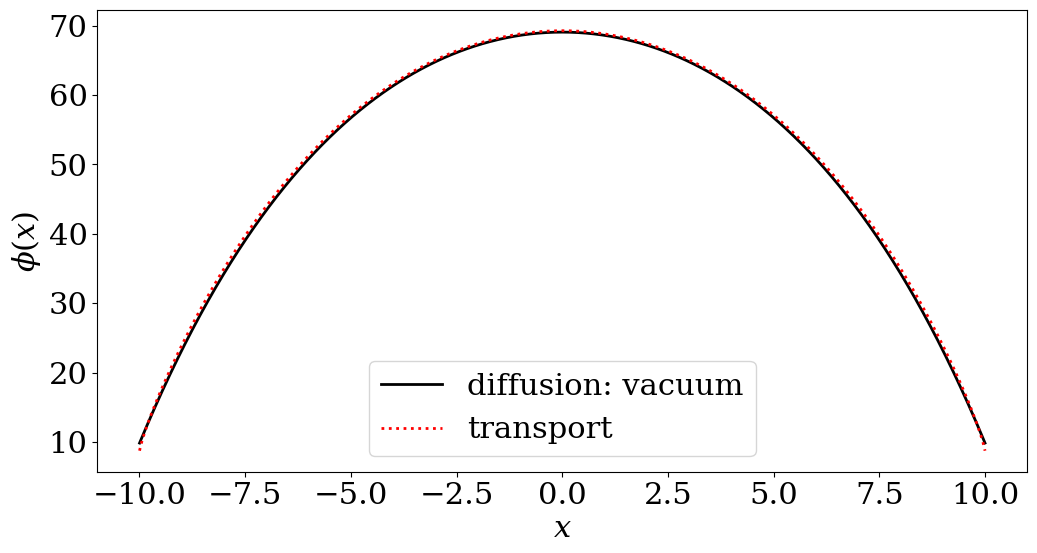

In [22]:
plt.plot(x_vals, phi_diff, 'k')
plt.plot(x_vals, phi_tran, 'r:')
plt.xlabel('$x$'); plt.ylabel("$\phi(x)$");
plt.legend(["diffusion: vacuum", "transport"]);

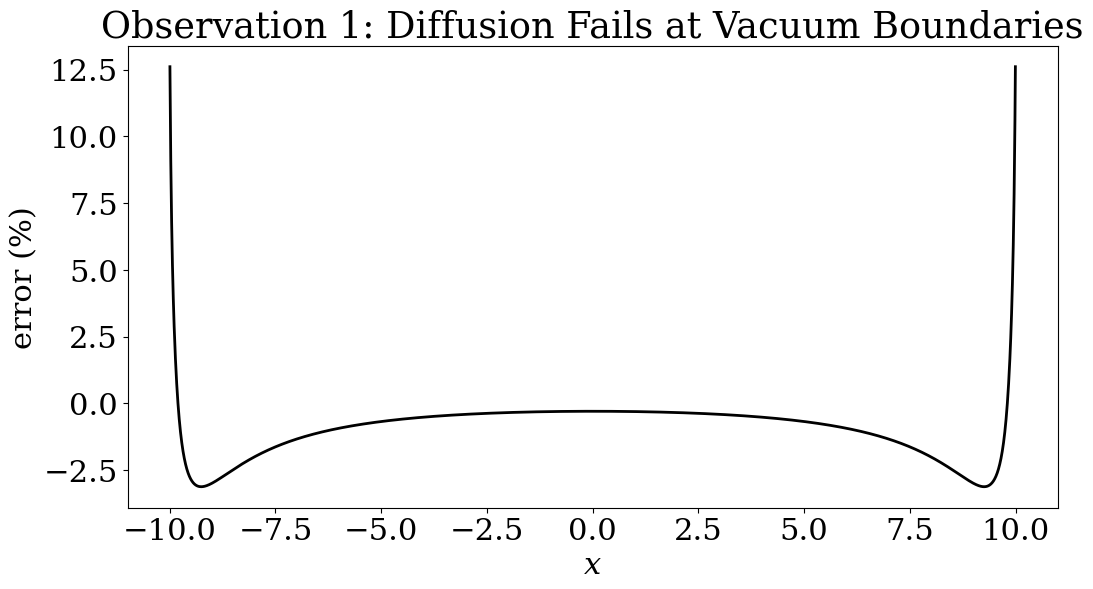

In [23]:
plt.plot(x_vals, 100*(phi_diff-phi_tran)/phi_tran, "k-")
plt.xlabel('$x$'); plt.ylabel("error (%)");
plt.title("Observation 1: Diffusion Fails at Vacuum Boundaries");

## Example 2: Localized Source with Reflecting Conditions

    SI Final: Number Iters: 1629  Error:  0.000000000  Sweeps:   1629 
  GS Final: Number Iters:   0  Error:  0.000000000  Sweeps:   1629 
PCILUT...construction complete.
    Starting SI.
      group 0


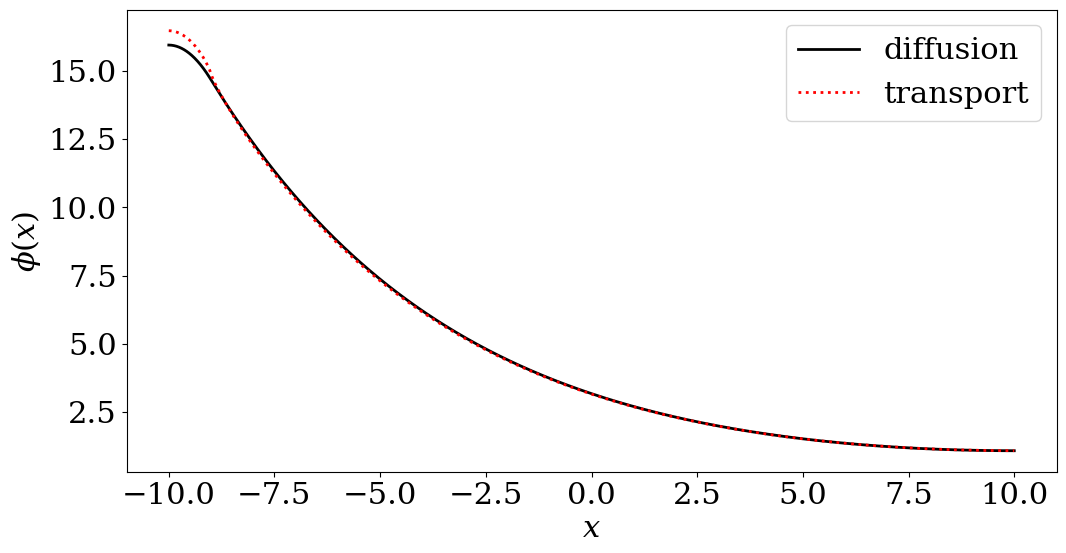

In [16]:
source_map = [1] + [0]*19
material_map = [0]*20
phi_diff, x_vals = solve(material_map, source_map, "diffusion", "reflect", "reflect")
phi_tran, x_vals = solve(material_map, source_map, "dd", "reflect", "reflect")

plt.plot(x_vals, phi_diff, 'k')
plt.plot(x_vals, phi_tran, 'r:')
plt.xlabel('$x$'); plt.ylabel("$\phi(x)$");
plt.legend(["diffusion", "transport"]);

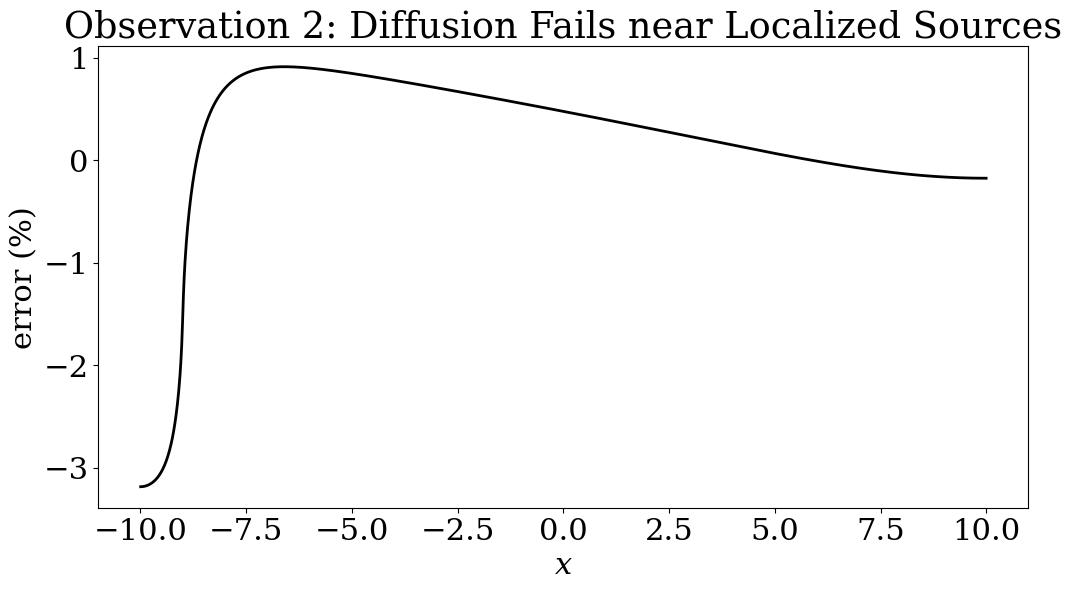

In [17]:
plt.plot(x_vals, 100*(phi_diff-phi_tran)/phi_tran, "k-")
plt.xlabel('$x$'); plt.ylabel("error (%)");
plt.title("Observation 2: Diffusion Fails near Localized Sources");

## Example 3: Localized Absorber with Uniform Source and Reflecting Conditions

    SI Final: Number Iters: 2495  Error:  0.000000000  Sweeps:   2495 
  GS Final: Number Iters:   0  Error:  0.000000000  Sweeps:   2495 
PCILUT...construction complete.
    Starting SI.
      group 0


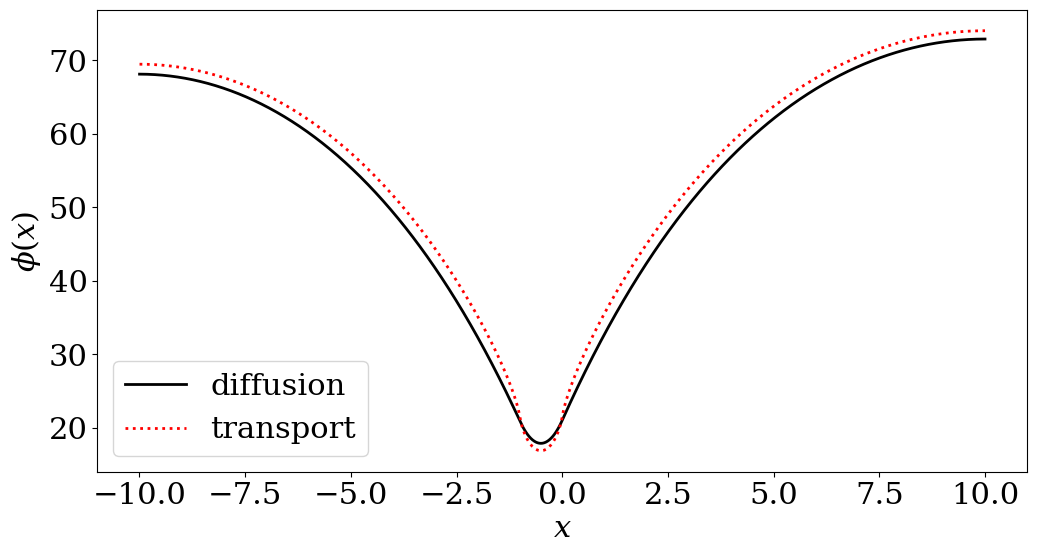

In [18]:
source_map = [1]*20
material_map = [0]*20
material_map[9] = 1
phi_diff, x_vals = solve(material_map, source_map, "diffusion", "reflect", "reflect")
phi_tran, x_vals = solve(material_map, source_map, "dd", "reflect", "reflect")

plt.plot(x_vals, phi_diff, 'k')
plt.plot(x_vals, phi_tran, 'r:')
plt.xlabel('$x$'); plt.ylabel("$\phi(x)$");
plt.legend(["diffusion", "transport"]);

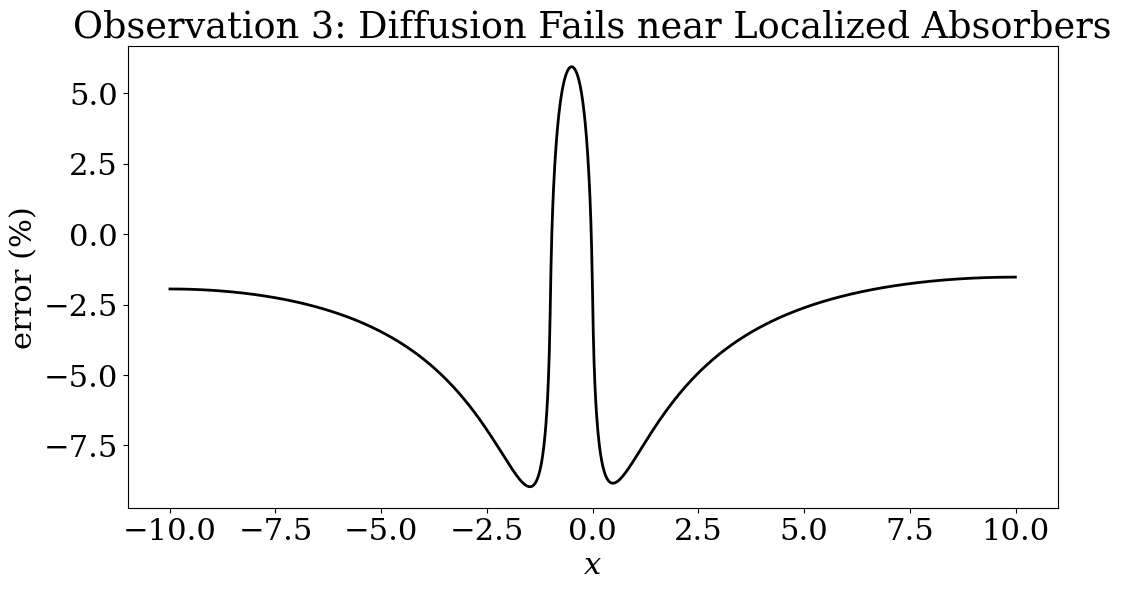

In [19]:
plt.plot(x_vals, 100*(phi_diff-phi_tran)/phi_tran, 'k-')
plt.xlabel('$x$'); plt.ylabel("error (%)");
plt.title("Observation 3: Diffusion Fails near Localized Absorbers");

## Summary of Observations

Predictions from diffusion theory deviate from the more rigorous transport theory near

  1. vacuum conditions
  2. localized sources
  3. localized (changes in) absorption

So, what the heck is *transport theory* doing different?

First, a new unknown.  Assume have both a spatial location $\vec{r}$ and a direction $\hat{\Omega} = (\theta, \varphi)$ but all have the same energy (and speed).  Then the neutron density is written $n(\vec{r}, \hat{\Omega})$ and

$$
   \psi(\vec{r}, \hat{\Omega}) = v n(\vec{r}, \hat{\Omega}) = \text{angular flux} \, .
$$


Of course, $\psi(\vec{r}, \hat{\Omega})$ is new to use, but it's closely related to two quantities we've seen a lot:

$$
  \phi(\vec{r}) = \int_{4\pi}  \psi(\vec{r}, \hat{\Omega}) d\Omega  = \text{flux}\, 
$$


$$
   \vec{J}(\vec{r}) = \int_{4\pi} \hat{\Omega} \psi(\vec{r}, \hat{\Omega}) d\Omega = \text{current} \, 
$$


In slab geometry, $\hat{\Omega}$ reduces to $\theta$ (the angle of travel relative to the positive $x$ axis), and with $\mu = \cos{\theta}$, we have

$$
 \phi(x) = \int^{1}_{-1} \psi(x, \mu) d\mu \qquad \text{and} \qquad J(x) = \int^{1}_{-1} \mu \psi(x, \mu) d\mu \, .
$$


The equation that governs $\psi(x, \mu)$ is the *transport equation*.  If scattering is isotropic in the lab system (i.e., the average scattering cosine is $\bar{\mu}_0 = 0$), we have

$$
  \mu \frac{\partial \psi}{\partial x} + \Sigma_t \psi(x, \mu) = \frac{\Sigma_s}{2} \phi(x) + \frac{s'''(x)}{2} \, ,
  \tag{1}
$$

subject to 

$$
  \psi(x_L, \mu) = \psi_L, \, \mu > 0 \qquad \text{and} \qquad \psi(x_R, \mu) = \psi_R, \, \mu < 0 \, .
$$

Here, $\psi_L = \psi_R = 0$ represents a true vacuum condition.

Treating $\mu$ is an important part of solving problems in transport theory.  Let's keep our life simple and guess that 

$$
  \psi(x, \mu) = \psi_0(x) + \mu \psi_1(x) \qquad \longrightarrow \qquad \phi(x) = 2\psi_0(x) \quad \text{and} \quad J(x) = \frac{3}{2}\psi_1(x) \, .
$$

Plugging this into the NTE leads to

$$
  \displaystyle \mu \frac{d}{d x} \psi_{0}{\left(x \right)} +  \mu^{2} \frac{d}{d x} \psi_{1}{\left(x \right)}  + \Sigma_{t} ( \psi_{0}{\left(x \right)} + \mu \psi_{1}{\left(x \right)} ) = \Sigma_{s} \psi_{0}{\left(x \right)} + \frac{s'''{\left(x \right)}}{2} \, .
  \tag{2}
$$

Now, integrate Eq. (2) over $\mu$ to get

$$
  \frac{2}{3}\frac{d \psi_1}{dx} + 2\Sigma_t \psi_0(x) = 2\Sigma_s \psi_0(x) + s'''(x) \, .
  \tag{3}
$$

Similarly, multiply Eq. (2) by $\mu$ and integrate again to get

$$
  \frac{2}{3} \frac{d\psi_0}{dx} = -\frac{2\Sigma_t}{3} \psi_1(x) \, .
  \tag{4}
$$

From (4), we have

$$
  \psi_1(x) = -\frac{1}{\Sigma_t} \frac{d\psi_0}{dx} \longrightarrow \boxed{J(x) 
    = -\frac{1}{3\Sigma_t} \frac{d\phi}{dx} = -D \frac{d\phi}{dx} } \, ,
  \tag{5}
$$

and substituting this into Eq. (3) and moving scattering to the left, we have

$$
  -\frac{2}{3\Sigma_t}\frac{d^2\psi_0}{dx^2} + 2(\Sigma_t-\Sigma_s)\psi_0(x) = s'''(x) 
  \longrightarrow \boxed{-D\phi'' + \Sigma_a \phi(x) = s'''(x)} \, .
  \tag{6} 
$$


In summary, diffusion theory is equivalent to assuming that the distribution of neutron directions with respect to each Cartesian axis is linear.   Things like vacuum boundaries (that's a *step* function in angle!), strong absorbers (that's exponential attenuations!), and localized sources (that's again like a *step* function) all break that assumption to varying degrees!